# <center> **金融时间序列（二）**</center>

## **1. 输入库包**

In [1]:
from scipy import stats
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import arch

## **2. 取出数据**

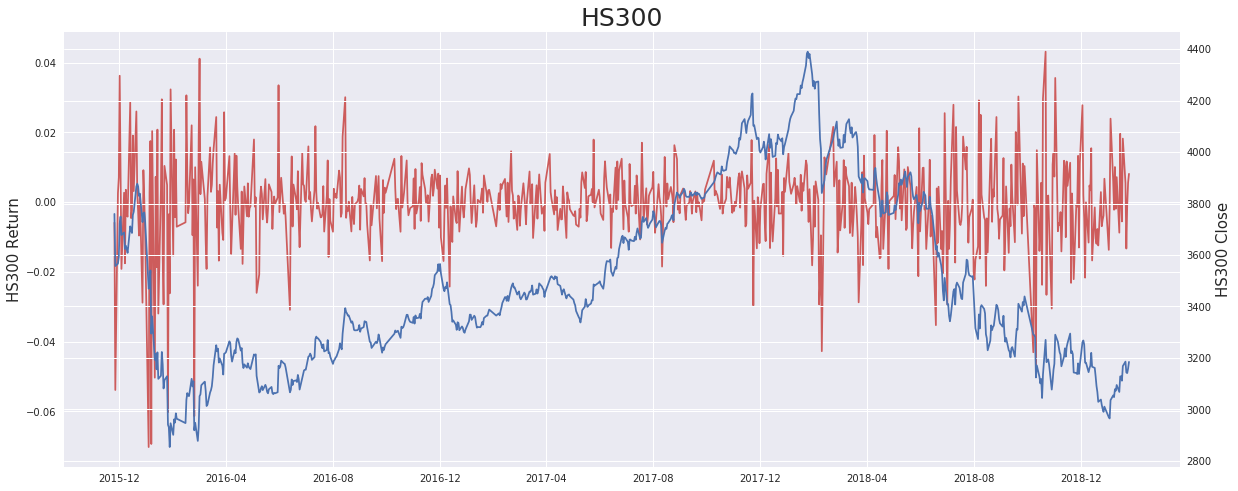

In [2]:
HS300_close=get_price(['000300.SH'], '20151125', '20190125', '1d', ['close'], True, None,is_panel=1)['close']
HS300_close.columns=['HS300_close']
HS300_close['return']=HS300_close['HS300_close'].pct_change()
HS300_close.dropna(inplace=True)
datetime=pd.to_datetime(HS300_close.index)
fig,ax=plt.subplots(figsize=(20,8))
rect1=ax.plot(datetime,HS300_close['return'],color='IndianRed')
ax.set_ylabel('HS300 Return',size=15)
ax=ax.twinx()
rect2=ax.plot(datetime,HS300_close['HS300_close'])
ax.set_ylabel('HS300 Close',size=15)
plt.title('HS300',size=25)

## **3. ARCH 模型**

ARCH模型由两个方程组成：<br/>

<img src="http://u.thsi.cn/imgsrc/sns/4b5fb82198edfe09b9a96a0f683afdf5_277_78.png" width = "120" height = "120" div align=center />
<img src="http://u.thsi.cn/imgsrc/sns/47a3d307d82b1642d022e4fe6141c328_914_110.png" width = "400" height = "400" div align=center /><br/>
<img src="http://u.thsi.cn/imgsrc/sns/f9cbed9de223761d76df834706e3af29_590_96.png" width = "240" height = "240" div align=center /><br/>
其中,{ϵt} 是均值为0,方差为1的独立同分布随机变量序列, α0>0,α1,⋯,αm≥0, σ2t为条件异方差.<br/><br/>
在金融时间序列（上）中，我们使用的模型干扰项的方差被假设为恒定。但是现实情况下市场呈现出波动的集聚性，在这种情况下假设方差为恒定是不合适的。ARCH模型将采用某种自回归形式来刻划方差的变异，从上面公式看出，过去较大的平方“扰动”会导致信息at有较大的条件异方差。这意味着：在ARCH的框架下，大的"扰动"会倾向于紧接着出现另一个大的"扰动"。这与波动率聚集的现象相似.<br/>

** 基本思想：**
1. 资产收益率的扰动序列at是前后不相关的， 但是前后不独立.
<img src="http://u.thsi.cn/imgsrc/sns/db2d1dcc03134c43c099befabd1c7fde_507_77.png" width = "200" height = "200" div align=center /><br/>
2. at的不独立性可以用at平方的滞后值的线性组合表示.<br/>


** ARCH模型波动率特征：**<br/>
（1）存在波动率聚集现象.<br/>
（2）波动率以连续时间变化，很少发生跳跃.<br/>
（3）波动率不会发散到无穷，波动率往往是平稳的.<br/>
（4）波动率对价格大幅上升和大幅下降的反应是不同的，这个现象为杠杆效应.<br/><br/>



** 对资产收益率序列建立波动率模型我们进行以下4个步骤：**<br/> 
（1）通过检验数据前后相关性建立一个均值方程，例如：AR或者ARMA等模型。如果有必要，对收益率序列建立一个计量经济模型来消除任何的线性依赖.<br/>
（2）对均值方程的残差进行ARCH效应检验. <br/>
（3）如果ARCH效应在统计上是显著的，则指定一个波动率模型<br/>
（4）仔细检验所拟合的模型，如果有必要则进行改进.<br/>


### **3.1 建立均值方程**

**1.检验序列平稳性，p_value<0.05,则序列平稳**

In [3]:
adftest_return=sm.tsa.stattools.adfuller(HS300_close['return'])
adftest_return_df=pd.DataFrame(index=["p-value"],columns=["return"])
adftest_return_df.loc["p-value"]["return"] = adftest_return[1]
adftest_return_df

,return
p-value,2.63546e-11


**2.确定均值方程的阶数为14**

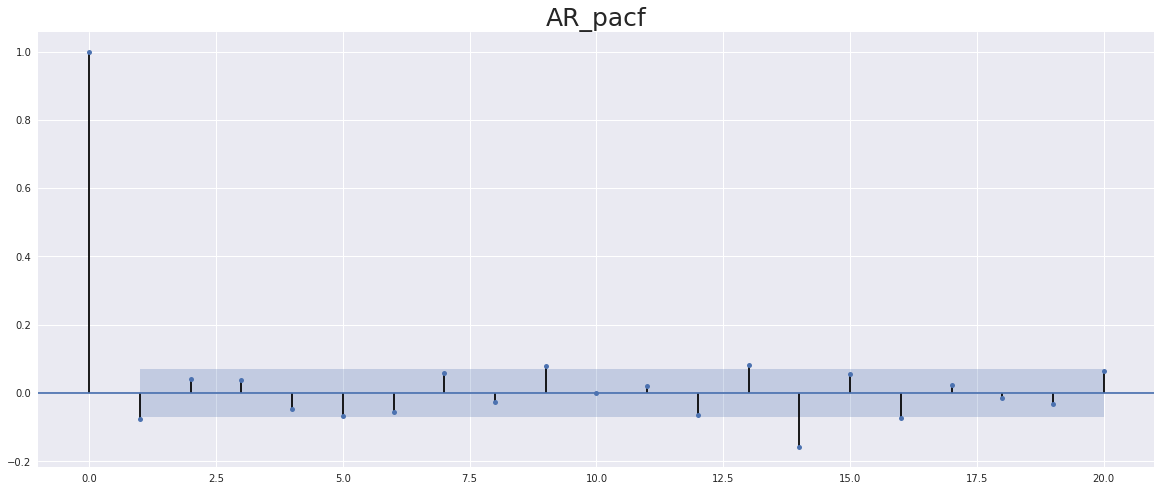

In [4]:
fig,ax = plt.subplots(figsize=(20,8))
fig=sm.graphics.tsa.plot_pacf(HS300_close['return'],lags=20,ax=ax)
plt.title("AR_pacf",size=25)


** 3. AR(14)模型建立**

In [5]:
AR_14_model=sm.tsa.ARMA(HS300_close['return'],(14,0)).fit()

** 4.对残差的ARCH效应检验**

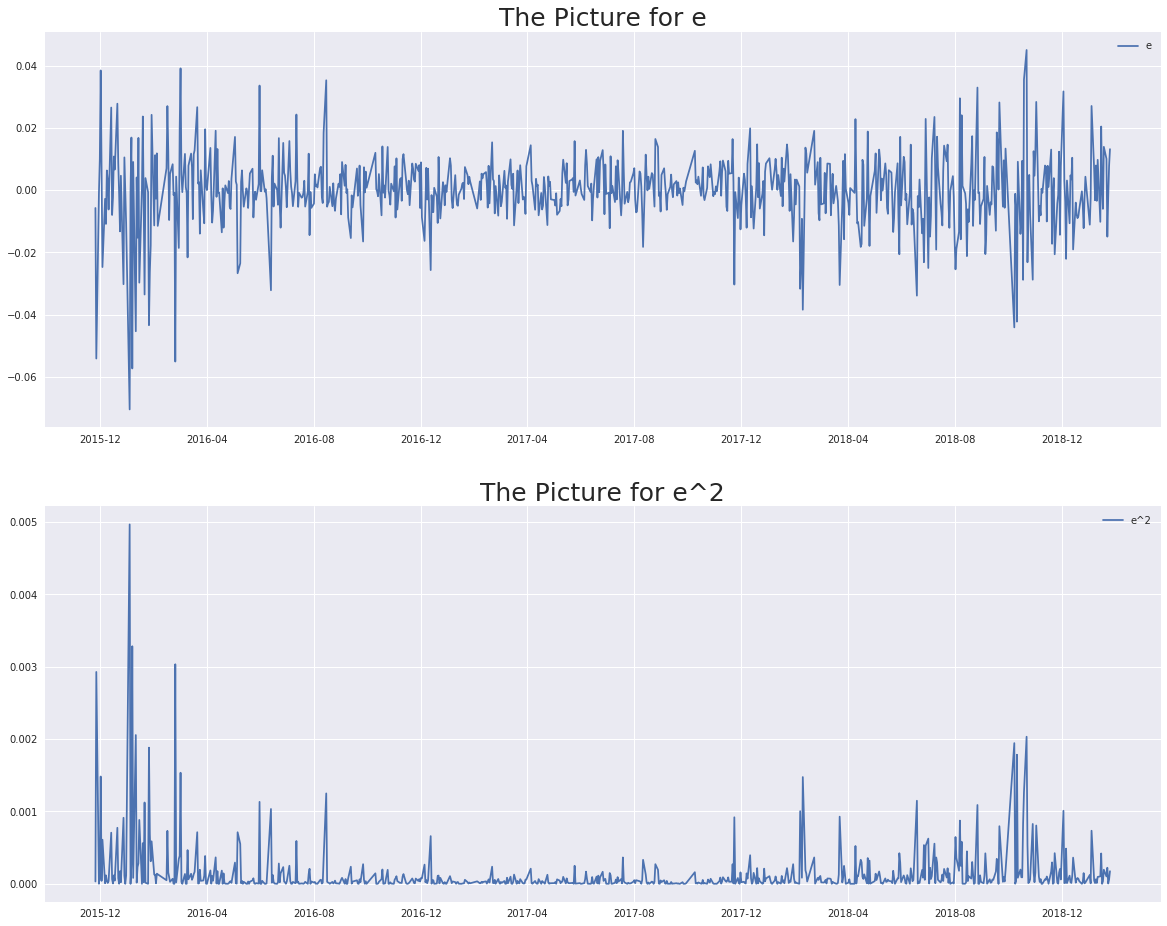

In [6]:
e=HS300_close['return']-AR_14_model.fittedvalues
esquare=np.square(e)
plt.figure(figsize=(20,16))
plt.subplot(211)
plt.plot(e,label='e')
plt.legend()
plt.title('The Picture for e',size=25)

plt.subplot(212)
plt.plot(esquare,label='e^2')
plt.legend()
plt.title('The Picture for e^2',size=25)

** 5. 对{a2t}序列进行混成检验**<br/><br/>
原假设H0:序列没有相关性<br/>
备择假设H1:序列具有相关性,即P_value<0.05

In [7]:
ACF,Q_test,P_value=sm.tsa.acf(esquare,nlags=15,qstat=True)
df=np.c_[range(1,16),ACF[1:],Q_test,P_value]
df=pd.DataFrame(df,columns=['lags','Autocorrelation','Q_test','P_value'])
df

,lags,Autocorrelation,Q_test,P_value
0,1.0,0.038802,1.171372,2.791195e-01
1,2.0,0.107967,10.252249,5.939535e-03
2,3.0,0.277827,70.460243,3.401750e-15
3,4.0,0.109718,79.862383,1.862766e-16
4,5.0,0.154297,98.480950,1.104439e-19
5,6.0,0.069512,102.264590,8.450257e-20
6,7.0,0.103845,110.719908,6.510068e-21
7,8.0,0.092298,117.408085,1.136024e-21
8,9.0,0.125563,129.802213,1.302362e-23
9,10.0,0.093389,136.667394,2.028482e-24


** 除了lag1, 其他p-value均小于显著性水平0.05. 故我们拒绝原假设, 即认为序列具有相关性. 因此具有ARCH效应.**

** 6. 确定ARCH模型的阶次**

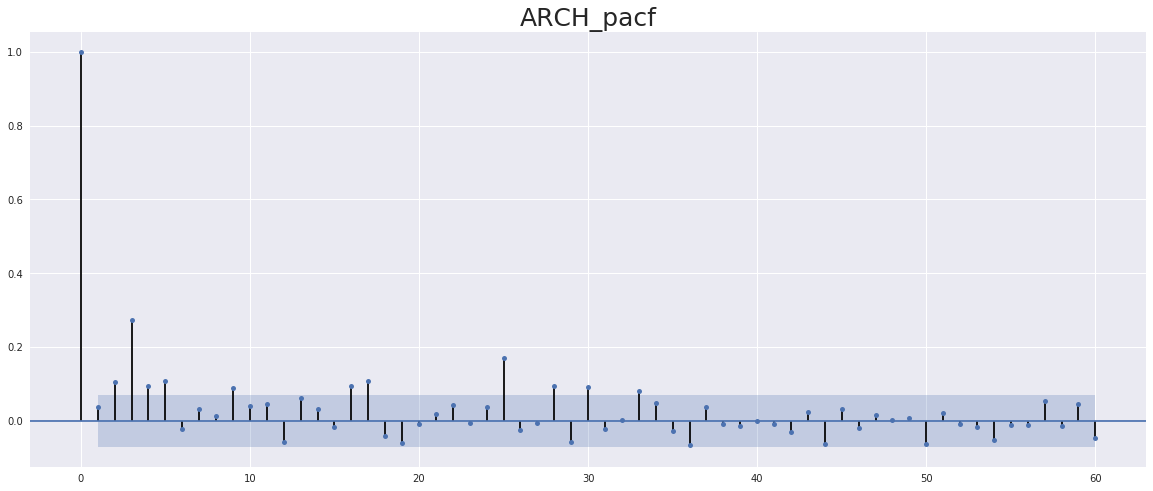

In [8]:
fig,ax = plt.subplots(figsize=(20,8))
fig=sm.graphics.tsa.plot_pacf(esquare,lags=60,ax=ax)
plt.title("ARCH_pacf",size=25)

** 7.数据集分类，ARCH模型拟合**

In [9]:
train_ARCH =HS300_close['return'][:-30]
test_ARCH = HS300_close['return'][-30:]
am_ARCH = arch.arch_model(train_ARCH, mean='AR', lags=14, vol='ARCH', p=5) 
res_ARCH = am_ARCH.fit()

Iteration:      1,   Func. Count:     23,   Neg. LLF: -2287.241261383542
Iteration:      2,   Func. Count:     54,   Neg. LLF: -2289.2806899658744
Iteration:      3,   Func. Count:     81,   Neg. LLF: -2299.487299442878
Iteration:      4,   Func. Count:    111,   Neg. LLF: -2299.488537589991
Iteration:      5,   Func. Count:    138,   Neg. LLF: -2299.539688181325
Iteration:      6,   Func. Count:    165,   Neg. LLF: -2300.3921520725444
Iteration:      7,   Func. Count:    193,   Neg. LLF: -2300.3945887010123
Iteration:      8,   Func. Count:    223,   Neg. LLF: -2300.416008067117
Iteration:      9,   Func. Count:    252,   Neg. LLF: -2300.416246490519
Iteration:     10,   Func. Count:    282,   Neg. LLF: -2300.416491005354
Iteration:     11,   Func. Count:    309,   Neg. LLF: -2300.436090884589
Iteration:     12,   Func. Count:    338,   Neg. LLF: -2300.4449000229947
Iteration:     13,   Func. Count:    368,   Neg. LLF: -2300.4449285249225
Optimization terminated successfully.    (Exit

In [10]:
res_ARCH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - ARCH Model Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.039
Mean Model:                        AR   Adj. R-squared:                  0.020
Vol Model:                       ARCH   Log-Likelihood:                2300.44
Distribution:                  Normal   AIC:                          -4558.89
Method:            Maximum Likelihood   BIC:                          -4462.41
                                        No. Observations:                  731
Date:                Tue, Feb 12 2019   Df Residuals:                      710
Time:                        10:13:15   Df Model:                           21
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       6.1884e-04  3.771e-04      1.641      0.101 [-1.202e-04,1.358e-03]
return[1]       0.0346  4.613e-02      0.751      0.453   [-5.577e-02,  0.125]
return[2]  -4.6119e-03  6.719e-02 -6.864e-02      0.945      [ -0.136,  0.127]
return[3]       0.0140  6.424e-02      0.218      0.827      [ -0.112,  0.140]
return[4]      -0.1082  6.087e-02     -1.777  7.549e-02    [ -0.227,1.111e-02]
return[5]      -0.0223  8.176e-02     -0.273      0.785      [ -0.183,  0.138]
return[6]      -0.0588  5.213e-02     -1.129      0.259    [ -0.161,4.333e-02]
return[7]   5.7600e-04  6.898e-02  8.351e-03      0.993      [ -0.135,  0.136]
return[8]      -0.0325  5.890e-02     -0.552      0.581    [ -0.148,8.293e-02]
return[9]       0.0849  8.451e-02      1.004      0.315   [-8.078e-02,  0.250]
return[10]      0.0136  7.895e-02      0.172      0.864      [ -0.141,  0.168]
return[11] -4.8524e-03  8.266e-02 -5.871e-02      0.953      [ -0.167,  0.157]
return[12]     -0.0709      0.118     -0.601      0.548      [ -0.302,  0.161]
return[13]      0.0659  9.988e-02      0.660      0.509      [ -0.130,  0.262]
return[14]     -0.0769  9.749e-02     -0.789      0.430      [ -0.268,  0.114]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.8761e-05  1.084e-05      5.422  5.902e-08 [3.752e-05,8.000e-05]
alpha[1]       0.1098  9.451e-02      1.162      0.245  [-7.545e-02,  0.295]
alpha[2]       0.1098      0.138      0.794      0.427     [ -0.161,  0.381]
alpha[3]       0.1103  9.251e-02      1.193      0.233  [-7.097e-02,  0.292]
alpha[4]       0.1112  8.079e-02      1.376      0.169  [-4.718e-02,  0.269]
alpha[5]       0.1098      0.123      0.894      0.371     [ -0.131,  0.350]
============================================================================

Covariance estimator: robust
"""

In [11]:
res_ARCH.params

Const         0.000619
return[1]     0.034636
return[2]    -0.004612
return[3]     0.014017
return[4]    -0.108193
return[5]    -0.022286
return[6]    -0.058846
return[7]     0.000576
return[8]    -0.032511
return[9]     0.084855
return[10]    0.013564
return[11]   -0.004852
return[12]   -0.070933
return[13]    0.065907
return[14]   -0.076887
omega         0.000059
alpha[1]      0.109790
alpha[2]      0.109790
alpha[3]      0.110339
alpha[4]      0.111160
alpha[5]      0.109790
Name: params, dtype: float64

** 8. ARCH模型预测**

In [12]:
len(train_ARCH)

745

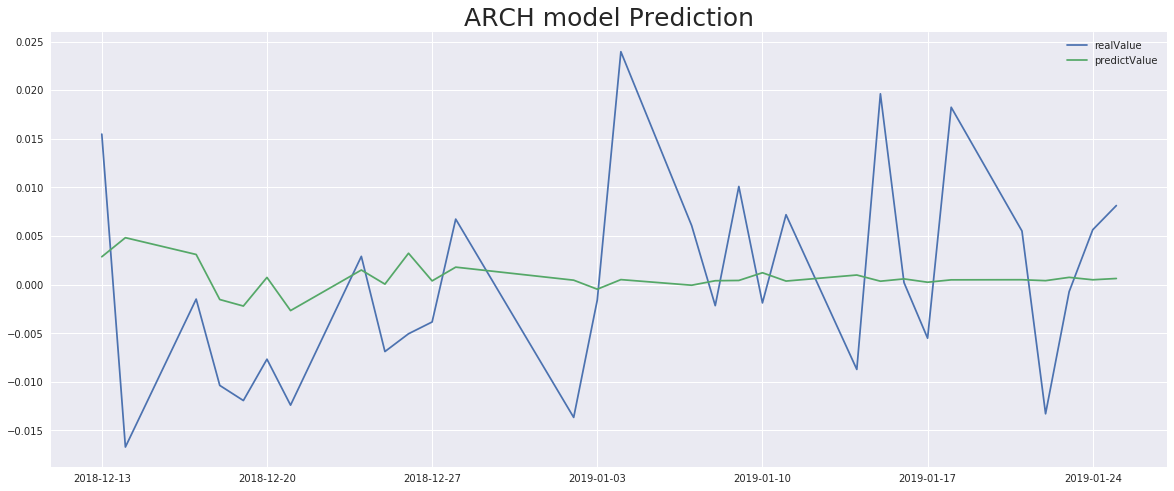

In [13]:
pre_ARCH = res_ARCH.forecast(horizon=30,start=744).mean
pre_ARCH=pre_ARCH.iloc[744]
pre_ARCH.index=test_ARCH.index

plt.figure(figsize=(20,8))
plt.plot(test_ARCH,label='realValue')
plt.plot(pre_ARCH,label='predictValue')
plt.title('ARCH model Prediction',size=25)
plt.legend()

## **4. GARCH 模型**

对于一个对数收益率序列rt，令：
<img src="http://u.thsi.cn/imgsrc/sns/cf54450d620b11042348c3ccd82531fa_756_80.png" width = "300" height = "300" div align=center /><br/>
如果at满足以下式子：<br/>
<img src="http://u.thsi.cn/imgsrc/sns/4b21fcb1959163f5b75eb3a3e3b232da_1206_184.png" width = "500" height = "500" div align=center /><br/>
<img src="http://u.thsi.cn/imgsrc/sns/9a7b1f049b95e9ccdd9310e6d2fd6351_589_93.png" width = "270" height = "270" div align=center /><br/>
<img src="http://u.thsi.cn/imgsrc/sns/93a99e06d113c3587960395e661c25ee_712_92.png" width = "290" height = "290" div align=center /><br/>
则称at服从GARCH模型,其中,{ϵt} 是均值为0,方差为1的独立同分布随机变量序列.

** 1. 数据集分类，GARCH模型拟合**

In [142]:
train_GARCH =HS300_close['return'][:-30]
test_GARCH = HS300_close['return'][-30:]
am_GARCH = arch.arch_model(train_GARCH, mean='AR', lags=14, vol='GARCH') 
res_GARCH = am_GARCH.fit()

Iteration:      1,   Func. Count:     20,   Neg. LLF: -2322.719676744772
Iteration:      2,   Func. Count:     48,   Neg. LLF: -2324.118636827964
Iteration:      3,   Func. Count:     78,   Neg. LLF: -2323.6843401398555
Iteration:      4,   Func. Count:    108,   Neg. LLF: -2324.1246848237706
Iteration:      5,   Func. Count:    133,   Neg. LLF: -2324.1264594013755
Iteration:      6,   Func. Count:    163,   Neg. LLF: -2316.849320551835
Iteration:      7,   Func. Count:    193,   Neg. LLF: -2328.0083395660868
Iteration:      8,   Func. Count:    223,   Neg. LLF: -2327.4637810024988
Iteration:      9,   Func. Count:    251,   Neg. LLF: -2328.0231532432426
Iteration:     10,   Func. Count:    281,   Neg. LLF: -2325.763855473391
Iteration:     11,   Func. Count:    311,   Neg. LLF: -2328.0188277867
Iteration:     12,   Func. Count:    338,   Neg. LLF: -2328.024075604725
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2328.024084172148
 

/opt/conda/lib/python3.5/site-packages/arch/univariate/base.py:517: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [15]:
res_GARCH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                 return   R-squared:                       0.071
Mean Model:                        AR   Adj. R-squared:                  0.053
Vol Model:                      GARCH   Log-Likelihood:                2328.02
Distribution:                  Normal   AIC:                          -4620.05
Method:            Maximum Likelihood   BIC:                          -4537.35
                                        No. Observations:                  731
Date:                Tue, Feb 12 2019   Df Residuals:                      713
Time:                        10:13:35   Df Model:                           18
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       4.3118e-04  3.001e-04      1.437      0.151 [-1.570e-04,1.019e-03]
return[1]      -0.0426  3.569e-02     -1.193      0.233    [ -0.113,2.737e-02]
return[2]       0.0299  3.594e-02      0.832      0.406   [-4.054e-02,  0.100]
return[3]       0.0652  4.003e-02      1.628      0.103   [-1.327e-02,  0.144]
return[4]      -0.0582  3.710e-02     -1.568      0.117    [ -0.131,1.454e-02]
return[5]      -0.0575  3.989e-02     -1.441      0.150    [ -0.136,2.072e-02]
return[6]      -0.0528  3.239e-02     -1.631      0.103    [ -0.116,1.066e-02]
return[7]       0.0393  3.921e-02      1.002      0.316   [-3.756e-02,  0.116]
return[8]      -0.0306  3.370e-02     -0.908      0.364 [-9.665e-02,3.545e-02]
return[9]       0.0874  3.520e-02      2.484  1.298e-02    [1.845e-02,  0.156]
return[10] -7.3447e-03  3.654e-02     -0.201      0.841 [-7.897e-02,6.428e-02]
return[11]      0.0228  3.433e-02      0.664      0.507 [-4.448e-02,9.008e-02]
return[12]     -0.0516  3.641e-02     -1.418      0.156    [ -0.123,1.972e-02]
return[13]      0.0646  3.598e-02      1.796  7.250e-02   [-5.901e-03,  0.135]
return[14]     -0.1405  3.224e-02     -4.356  1.323e-05   [ -0.204,-7.727e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.6238e-06  4.121e-12  6.367e+05      0.000 [2.624e-06,2.624e-06]
alpha[1]       0.0500  1.510e-02      3.312  9.261e-04 [2.042e-02,7.960e-02]
beta[1]        0.9300  1.063e-02     87.477      0.000     [  0.909,  0.951]
============================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate sucessful convergence. The message was
Positive directional derivative for linesearch. See convergence_flag.
"""

In [16]:
res_GARCH.params

Const         0.000431
return[1]    -0.042592
return[2]     0.029893
return[3]     0.065190
return[4]    -0.058172
return[5]    -0.057475
return[6]    -0.052824
return[7]     0.039286
return[8]    -0.030600
return[9]     0.087443
return[10]   -0.007345
return[11]    0.022798
return[12]   -0.051641
return[13]    0.064623
return[14]   -0.140464
omega         0.000003
alpha[1]      0.050010
beta[1]       0.930000
Name: params, dtype: float64

** 2. GARCH模型预测**<br/>
前面ARCH模型，我们用来预测了收益率，然而直接预测收益率准确度并不是很高，因此很多时候我们主要用来预测波动率.
<img src="http://u.thsi.cn/imgsrc/sns/a3f56e1a14cf58d32c8c1a232efc8cae_1220_72.png" width = "600" height = "600" div align=center /><br/>
<img src="http://u.thsi.cn/imgsrc/sns/b6d358355e650b7a840a4a5a09c850dd_744_76.png" width = "400" height = "400" div align=center />

In [22]:
resid=res_GARCH.resid[-14:]                 #取出过去14天的残差at
params=np.array(res_GARCH.params[1:15])               #取出均值方程所有系数    
w_params=params[::-1]                       #倒转系数方向
w_params.dot(resid[-14:])

for i in range(30):
    resid_new=test_GARCH.iloc[i]-(res_GARCH.params[0]+w_params.dot(resid[-14:]))
    resid=np.append(resid,resid_new)
resid_final=resid[-30:]
resid_final_square=resid_final**2
resid_final_square


array([1.31265182e-04, 4.24223468e-04, 2.34277150e-05, 8.61572516e-05,
       7.61609044e-05, 9.93121008e-05, 6.07929980e-05, 9.97465719e-08,
       3.17377608e-05, 1.50034013e-04, 7.63315088e-06, 1.93504633e-05,
       1.31637564e-04, 1.60983709e-05, 6.62189736e-04, 2.51275329e-05,
       1.20477057e-05, 3.81599502e-05, 3.29924979e-06, 6.78092403e-05,
       8.81824346e-05, 3.51298854e-04, 1.00565226e-06, 6.70353037e-05,
       2.03613211e-04, 6.43136485e-05, 1.87956839e-04, 1.15415026e-05,
       4.33123654e-05, 1.57135491e-04])

In [54]:
volatility=res_GARCH.conditional_volatility[-1:]
for i in range(30):
    new_volatility=0.000003+0.05001*resid_final_square[i]+0.93*volatility[-1]
    volatility=np.append(volatility,new_volatility)
    
pre_volatility=volatility[-30:]
pre_volatility

array([0.01227059, 0.01143586, 0.01063952, 0.00990207, 0.00921573,
       0.0085786 , 0.00798413, 0.00742825, 0.00691286, 0.00643946,
       0.00599208, 0.0055766 , 0.00519582, 0.00483592, 0.00453352,
       0.00422043, 0.00392861, 0.00365851, 0.00340558, 0.00317358,
       0.00295884, 0.00277229, 0.00258128, 0.00240694, 0.00225164,
       0.00210024, 0.00196562, 0.00183161, 0.00170856, 0.00159982])

In [55]:
test_GARCH

2018-12-13    0.015481
2018-12-14   -0.016704
2018-12-17   -0.001489
2018-12-18   -0.010366
2018-12-19   -0.011923
2018-12-20   -0.007670
2018-12-21   -0.012395
2018-12-24    0.002906
2018-12-25   -0.006885
2018-12-26   -0.005054
2018-12-27   -0.003840
2018-12-28    0.006737
2019-01-02   -0.013658
2019-01-03   -0.001580
2019-01-04    0.023958
2019-01-07    0.006070
2019-01-08   -0.002161
2019-01-09    0.010097
2019-01-10   -0.001881
2019-01-11    0.007190
2019-01-14   -0.008722
2019-01-15    0.019625
2019-01-16    0.000211
2019-01-17   -0.005509
2019-01-18    0.018242
2019-01-21    0.005512
2019-01-22   -0.013284
2019-01-23   -0.000720
2019-01-24    0.005644
2019-01-25    0.008132
Name: return, dtype: float64

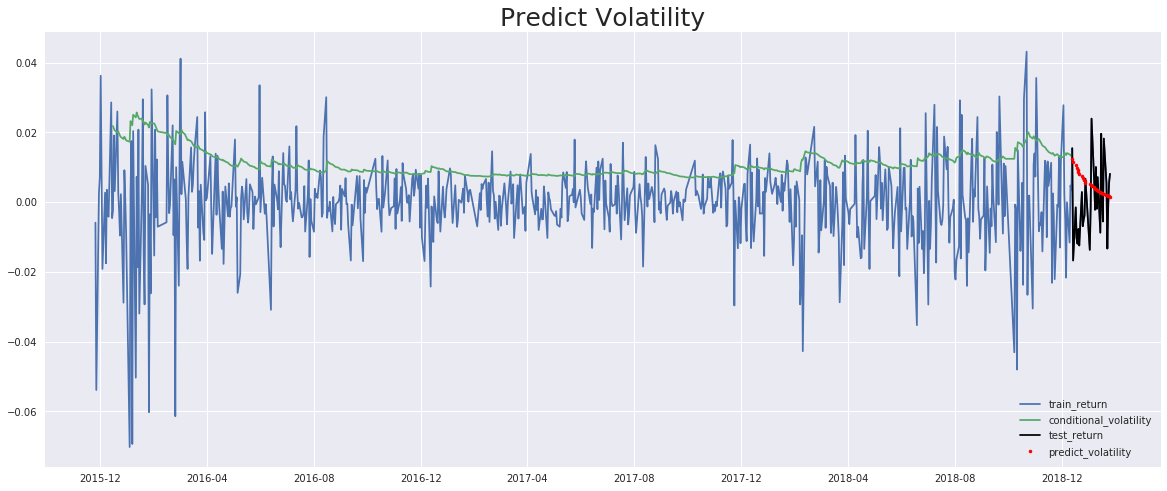

In [93]:
HS300_close.index=pd.to_datetime(HS300_close.index)
res_GARCH.conditional_volatility.index=pd.to_datetime(res_GARCH.conditional_volatility.index)

plt.figure(figsize=(20,8))
plt.plot(HS300_close['return'],label='train_return')
plt.plot(res_GARCH.conditional_volatility,label='conditional_volatility')
x=test_GARCH.index
plt.plot(test_GARCH,'black',label='test_return')
plt.plot(x,pre_volatility,'.r',label='predict_volatility')
plt.title('Predict Volatility',size=25)
plt.legend()

## **5. TGARCH 模型（ GJR-GARCH）**


TGARCH模型是另一个能够反映杠杆效应的波动率模型。同时现实中，当实际收益率低于均值方程时，波动率偏向于更大，为了衡量收益率波动的非对称性，我们引入TCAGCH模型。<br/>
<img src="http://u.thsi.cn/imgsrc/sns/8ce62dfc2b2cfe15f20c14a573a78d55_1179_198.png" width = "400" height = "400" div align=center />
其中N(t-i)的表达式如下（3个参数皆非负）：
<img src="http://u.thsi.cn/imgsrc/sns/8128d5264624c181c9c56426d642e446_610_188.png" width = "200" height = "200" div align=center />
<img src="http://u.thsi.cn/imgsrc/sns/f938699c3411e85372ebc276c97f1f09_2000_80.png" width = "620" height = "620" div align=left />

 ** 1.尝试使用**

In [114]:
T_GARCH=arch.arch_model(HS300_close['return'],p=1,o=1,q=1)   #每个参数只设定一位
res_GJR = T_GARCH.fit(disp='off')
res_GJR.summary()

/opt/conda/lib/python3.5/site-packages/arch/univariate/base.py:517: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                 return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                2453.58
Distribution:                  Normal   AIC:                          -4897.16
Method:            Maximum Likelihood   BIC:                          -4873.90
                                        No. Observations:                  775
Date:                Tue, Feb 12 2019   Df Residuals:                      770
Time:                        13:45:27   Df Model:                            5
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -3.0804e-04  3.361e-06    -91.660      0.000 [-3.146e-04,-3.015e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.8983e-06  2.753e-12  1.053e+06      0.000 [2.898e-06,2.898e-06]
alpha[1]       0.0500  5.526e-02      0.905      0.366  [-5.831e-02,  0.158]
gamma[1]       0.0500  5.041e-02      0.992      0.321  [-4.881e-02,  0.149]
beta[1]        0.9050  2.612e-02     34.642 5.959e-263     [  0.854,  0.956]
============================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate sucessful convergence. The message was
Positive directional derivative for linesearch. See convergence_flag.
"""

<img src="http://u.thsi.cn/imgsrc/sns/f01c07b519c13123944b8aec11c60e07_1160_76.png" width = "600" height = "600" div align=center />

In [115]:
res_GJR.params

mu         -0.000308
omega       0.000003
alpha[1]    0.050000
gamma[1]    0.050000
beta[1]     0.905000
Name: params, dtype: float64

** 2.预测波动率**

In [117]:
T_GARCH=arch.arch_model(train_GARCH,mean='AR',lags=14,p=1,o=1,q=1)   #每个参数只设定一位
res_GJR = T_GARCH.fit(disp='off')
res_GJR.summary()

/opt/conda/lib/python3.5/site-packages/arch/univariate/base.py:517: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         AR - GJR-GARCH Model Results                         
==============================================================================
Dep. Variable:                 return   R-squared:                       0.074
Mean Model:                        AR   Adj. R-squared:                  0.055
Vol Model:                  GJR-GARCH   Log-Likelihood:                2326.78
Distribution:                  Normal   AIC:                          -4615.55
Method:            Maximum Likelihood   BIC:                          -4528.26
                                        No. Observations:                  731
Date:                Tue, Feb 12 2019   Df Residuals:                      712
Time:                        13:47:37   Df Model:                           19
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       3.2016e-04  3.924e-04      0.816      0.415 [-4.490e-04,1.089e-03]
return[1]      -0.0550  3.850e-02     -1.429      0.153    [ -0.130,2.044e-02]
return[2]       0.0430  3.798e-02      1.131      0.258   [-3.148e-02,  0.117]
return[3]       0.0704  3.936e-02      1.790  7.348e-02   [-6.697e-03,  0.148]
return[4]      -0.0500  4.024e-02     -1.242      0.214    [ -0.129,2.889e-02]
return[5]      -0.0588  4.300e-02     -1.368      0.171    [ -0.143,2.546e-02]
return[6]      -0.0667  3.706e-02     -1.800  7.193e-02    [ -0.139,5.943e-03]
return[7]       0.0465  4.413e-02      1.053      0.292   [-4.002e-02,  0.133]
return[8]      -0.0397  3.615e-02     -1.099      0.272    [ -0.111,3.113e-02]
return[9]       0.0899  4.196e-02      2.142  3.216e-02    [7.657e-03,  0.172]
return[10] -9.6551e-03  3.854e-02     -0.251      0.802 [-8.519e-02,6.588e-02]
return[11]      0.0279  3.906e-02      0.715      0.475   [-4.865e-02,  0.104]
return[12]     -0.0473  3.907e-02     -1.210      0.226    [ -0.124,2.929e-02]
return[13]      0.0810  3.954e-02      2.048  4.060e-02    [3.466e-03,  0.158]
return[14]     -0.1633  3.341e-02     -4.887  1.023e-06   [ -0.229,-9.779e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.6111e-06  4.932e-12  5.294e+05      0.000 [2.611e-06,2.611e-06]
alpha[1]       0.0500  7.974e-02      0.627      0.531     [ -0.106,  0.206]
gamma[1]       0.0500  5.506e-02      0.908      0.364  [-5.792e-02,  0.158]
beta[1]        0.9050  4.554e-02     19.872  7.100e-88     [  0.816,  0.994]
============================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate sucessful convergence. The message was
Positive directional derivative for linesearch. See convergence_flag.
"""

<img src="http://u.thsi.cn/imgsrc/sns/9943fc422f2842ab8563ad39be6979a5_1156_76.png" width = "600" height = "600" div align=center />

In [121]:
resid=res_GJR.resid[-14:]                 #取出过去14天的残差at
params=np.array(res_GJR.params[1:15])               #取出均值方程所有系数    
w_params=params[::-1]                       #倒转系数方向
w_params.dot(resid[-14:])

for i in range(30):
    resid_new=test_GARCH.iloc[i]-(res_GJR.params[0]+w_params.dot(resid[-14:]))
    resid=np.append(resid,resid_new)
resid_final=resid[-30:]
resid_final_square=resid_final**2
resid_final_square


volatility=res_GJR.conditional_volatility[-1:]

for i in range(30):
    if resid_final[i]>=0:
        new_volatility2=2.6111e-06+0.05*resid_final_square[i]+0.905*volatility[-1]
    if resid_final[i]<0:
        new_volatility2=2.6111e-06+0.05*resid_final_square[i]+0.05*resid_final_square[i]+0.905*volatility[-1]
     
    volatility=np.append(volatility,new_volatility2)
    
pre_volatility2=volatility[-30:]
pre_volatility2

array([0.01181355, 0.01073732, 0.00972246, 0.0088096 , 0.00798311,
       0.00723773, 0.00655717, 0.00593685, 0.00537789, 0.00488642,
       0.00442548, 0.00400856, 0.0036425 , 0.00330061, 0.00302481,
       0.00274126, 0.00248462, 0.00225296, 0.00204187, 0.00185377,
       0.00168776, 0.00154715, 0.00140295, 0.00127983, 0.00117096,
       0.00106595, 0.00098665, 0.00089696, 0.00081688, 0.00075026])

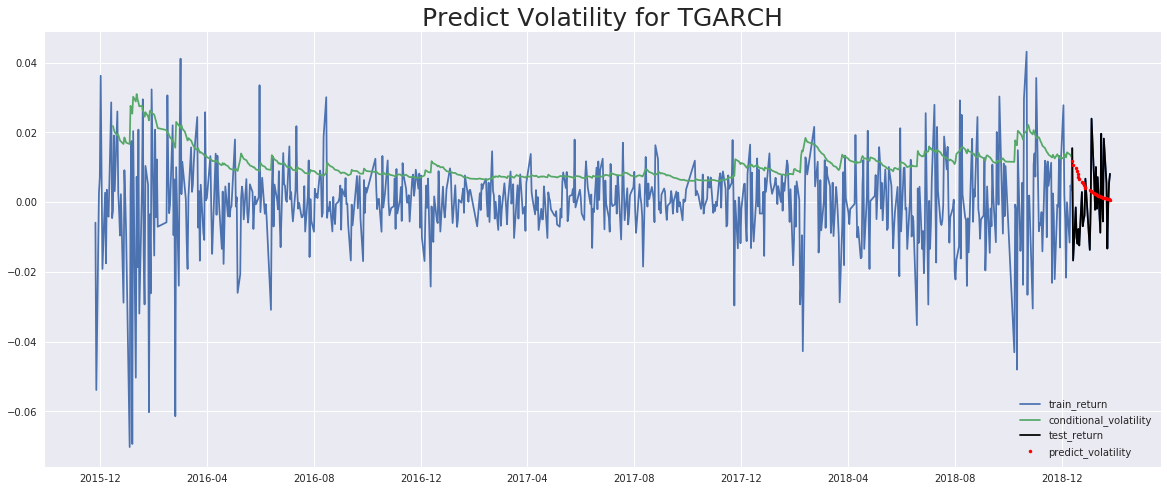

In [122]:

plt.figure(figsize=(20,8))
plt.plot(HS300_close['return'],label='train_return')
plt.plot(res_GJR.conditional_volatility,label='conditional_volatility')
x=test_GARCH.index
plt.plot(test_GARCH,'black',label='test_return')
plt.plot(x,pre_volatility2,'.r',label='predict_volatility')
plt.title('Predict Volatility for TGARCH',size=25)
plt.legend()

## **6. EGARCH 模型**

EGARCH的表达形式：
<img src="http://u.thsi.cn/imgsrc/sns/961afa64bf60a98069560626ceb0af3f_1265_178.png" width = "400" height = "400" div align=center />
我们可以看出，正的 at−1 对对数波动率的贡献为：
<img src="http://u.thsi.cn/imgsrc/sns/52c268b4ec589cb8ea65bb47e85bb7c8_216_92.png" width = "150" height = "150" div align=center />
负的 at−1 对对数波动率的贡献为：
<img src="http://u.thsi.cn/imgsrc/sns/a9441c4eab9568b901e67a7cc9fba4bd_212_104.png" width = "150" height = "150" div align=center />

In [143]:
am_EGARCH = arch.arch_model(train_GARCH, mean='AR',lags=14,vol='EGARCH',p=1,o=1,q=1) 
res_EGARCH = am_EGARCH.fit()
res_EGARCH.summary()

Iteration:      1,   Func. Count:     21,   Neg. LLF: -2326.023279716948
Iteration:      2,   Func. Count:     50,   Neg. LLF: -2327.75538643331
Iteration:      3,   Func. Count:     75,   Neg. LLF: -2332.9641537177768
Iteration:      4,   Func. Count:     99,   Neg. LLF: -2336.4718946129
Iteration:      5,   Func. Count:    124,   Neg. LLF: -2337.5857986384435
Iteration:      6,   Func. Count:    149,   Neg. LLF: -2337.8877108788315
Iteration:      7,   Func. Count:    173,   Neg. LLF: -2337.9744306294347
Iteration:      8,   Func. Count:    197,   Neg. LLF: -2338.0061904712775
Iteration:      9,   Func. Count:    221,   Neg. LLF: -2338.0368960602573
Iteration:     10,   Func. Count:    244,   Neg. LLF: -2338.1488006379004
Iteration:     11,   Func. Count:    267,   Neg. LLF: -2339.6189541011254
Iteration:     12,   Func. Count:    291,   Neg. LLF: -2341.2595072472322
Iteration:     13,   Func. Count:    315,   Neg. LLF: -2341.5926887257974
Iteration:     14,   Func. Count:    339,   

<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR - EGARCH Model Results                           
==============================================================================
Dep. Variable:                 return   R-squared:                       0.033
Mean Model:                        AR   Adj. R-squared:                  0.014
Vol Model:                     EGARCH   Log-Likelihood:                2345.99
Distribution:                  Normal   AIC:                          -4653.97
Method:            Maximum Likelihood   BIC:                          -4566.68
                                        No. Observations:                  731
Date:                Tue, Feb 12 2019   Df Residuals:                      712
Time:                        14:45:05   Df Model:                           19
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       4.6234e-04  3.380e-04      1.368      0.171 [-2.001e-04,1.125e-03]
return[1]  -6.5081e-03  7.736e-02 -8.412e-02      0.933      [ -0.158,  0.145]
return[2]  -4.1354e-03  4.109e-02     -0.101      0.920 [-8.467e-02,7.640e-02]
return[3]       0.0533  4.473e-02      1.191      0.234   [-3.441e-02,  0.141]
return[4]      -0.0808  6.172e-02     -1.309      0.191    [ -0.202,4.019e-02]
return[5]      -0.0754  4.793e-02     -1.572      0.116    [ -0.169,1.858e-02]
return[6]       0.0162  8.863e-02      0.183      0.855      [ -0.158,  0.190]
return[7]   7.1264e-04  8.221e-02  8.668e-03      0.993      [ -0.160,  0.162]
return[8]  -1.1580e-03  3.619e-02 -3.199e-02      0.974 [-7.210e-02,6.978e-02]
return[9]       0.0786  7.414e-02      1.060      0.289   [-6.675e-02,  0.224]
return[10]      0.0161  4.637e-02      0.347      0.728   [-7.479e-02,  0.107]
return[11]  1.2182e-03  5.696e-02  2.139e-02      0.983      [ -0.110,  0.113]
return[12]     -0.0733      0.102     -0.721      0.471      [ -0.273,  0.126]
return[13]  7.8594e-03  5.225e-02      0.150      0.880   [-9.455e-02,  0.110]
return[14]     -0.0518      0.130     -0.400      0.689      [ -0.306,  0.202]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         -0.0380  5.862e-02     -0.648      0.517    [ -0.153,7.688e-02]
alpha[1]       0.1039  3.470e-02      2.995  2.741e-03    [3.593e-02,  0.172]
gamma[1]   2.2808e-03  3.407e-02  6.694e-02      0.947 [-6.450e-02,6.906e-02]
beta[1]        0.9954  6.213e-03    160.224      0.000      [  0.983,  1.008]
=============================================================================

Covariance estimator: robust
"""

<img src="http://u.thsi.cn/imgsrc/sns/83460feeb9f30fb9f92f55b957227259_1268_136.png" width = "600" height = "600" div align=center />


In [144]:
import math
resid=res_EGARCH.resid[-14:]                 #取出过去14天的残差at
params=np.array(res_EGARCH.params[1:15])               #取出均值方程所有系数    
w_params=params[::-1]                       #倒转系数方向
w_params.dot(resid[-14:])

for i in range(30):
    resid_new=test_GARCH.iloc[i]-(res_EGARCH.params[0]+w_params.dot(resid[-14:]))
    resid=np.append(resid,resid_new)
resid_final=resid[-30:]


volatility=res_EGARCH.conditional_volatility[-1:]

for i in range(30):
    if resid_final[i]>=0:
        new_volatility3=math.exp(-0.038+0.1039*((resid_final_square[i]+2.2808e-03*resid_final_square[i])/volatility[-1])+0.9954*math.log(volatility[-1],math.e))
    if resid_final[i]<0:
        new_volatility3=math.exp(-0.038+0.1039*((-resid_final_square[i]+2.2808e-03*resid_final_square[i])/volatility[-1])+0.9954*math.log(volatility[-1],math.e))
     
    volatility=np.append(volatility,new_volatility3)
    
pre_volatility3=volatility[-30:]
pre_volatility3

array([0.01392485, 0.01362767, 0.01337873, 0.01312972, 0.01288666,
       0.0126464 , 0.01241761, 0.01219838, 0.01198153, 0.01175483,
       0.01154955, 0.01135125, 0.01114309, 0.01095026, 0.01083535,
       0.01065318, 0.01047129, 0.01029811, 0.01012468, 0.00996197,
       0.00978839, 0.00966124, 0.0095013 , 0.00933736, 0.00920527,
       0.00906263, 0.00889582, 0.00875073, 0.00861525, 0.00849457])

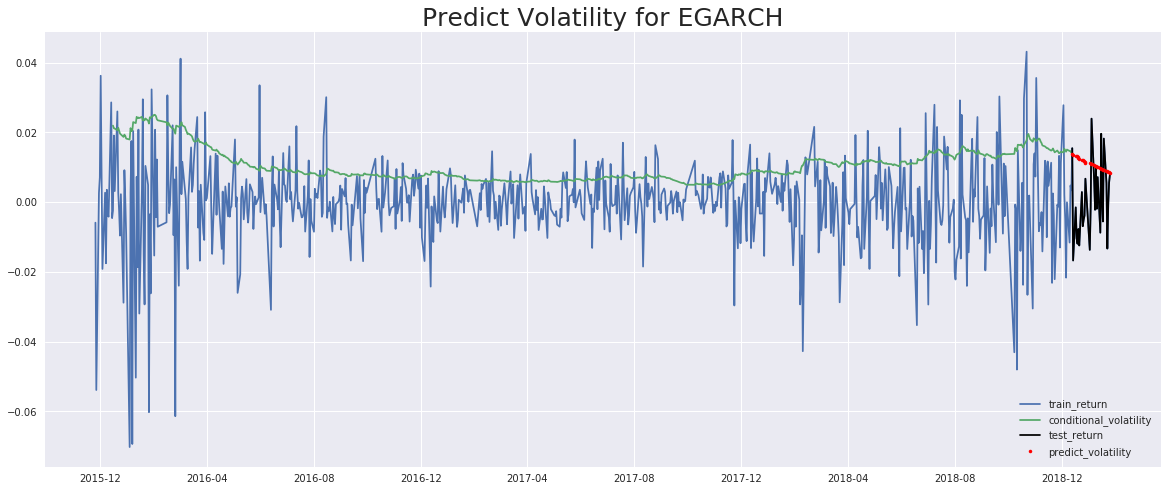

In [145]:
plt.figure(figsize=(20,8))
plt.plot(HS300_close['return'],label='train_return')
plt.plot(res_EGARCH.conditional_volatility,label='conditional_volatility')
x=test_GARCH.index
plt.plot(test_GARCH,'black',label='test_return')
plt.plot(x,pre_volatility3,'.r',label='predict_volatility')
plt.title('Predict Volatility for EGARCH',size=25)
plt.legend()

** 30天作为窗口太长，减小窗口**

In [146]:
train_GARCH =HS300_close['return'][:-10]
test_GARCH = HS300_close['return'][-10:]
am_EGARCH = arch.arch_model(train_GARCH, mean='AR',lags=14,vol='EGARCH',p=1,o=1,q=1) 
res_EGARCH = am_EGARCH.fit()
res_EGARCH.summary()

Iteration:      1,   Func. Count:     21,   Neg. LLF: -2389.0143131963787
Iteration:      2,   Func. Count:     50,   Neg. LLF: -2390.6508646560833
Iteration:      3,   Func. Count:     75,   Neg. LLF: -2396.1285525238573
Iteration:      4,   Func. Count:    100,   Neg. LLF: -2402.2227129073626
Iteration:      5,   Func. Count:    125,   Neg. LLF: -2403.571456597667
Iteration:      6,   Func. Count:    150,   Neg. LLF: -2403.818112448538
Iteration:      7,   Func. Count:    174,   Neg. LLF: -2403.9342512813714
Iteration:      8,   Func. Count:    198,   Neg. LLF: -2403.957012205336
Iteration:      9,   Func. Count:    222,   Neg. LLF: -2403.976360942928
Iteration:     10,   Func. Count:    245,   Neg. LLF: -2404.105164206606
Iteration:     11,   Func. Count:    269,   Neg. LLF: -2404.136233192079
Iteration:     12,   Func. Count:    292,   Neg. LLF: -2404.708099067235
Iteration:     13,   Func. Count:    316,   Neg. LLF: -2404.9624706609434
Iteration:     14,   Func. Count:    340,   N

<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR - EGARCH Model Results                           
==============================================================================
Dep. Variable:                 return   R-squared:                       0.034
Mean Model:                        AR   Adj. R-squared:                  0.016
Vol Model:                     EGARCH   Log-Likelihood:                2408.52
Distribution:                  Normal   AIC:                          -4779.04
Method:            Maximum Likelihood   BIC:                          -4691.23
                                        No. Observations:                  751
Date:                Tue, Feb 12 2019   Df Residuals:                      732
Time:                        14:45:24   Df Model:                           19
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
Const       4.4726e-04  6.946e-04      0.644      0.520  [-9.142e-04,1.809e-03]
return[1]  -6.8699e-03  5.857e-02     -0.117      0.907       [ -0.122,  0.108]
return[2]  -2.1259e-03  5.068e-02 -4.195e-02      0.967     [ -0.101,9.720e-02]
return[3]       0.0552  4.822e-02      1.146      0.252    [-3.926e-02,  0.150]
return[4]      -0.0742  9.646e-03     -7.690  1.477e-14 [-9.308e-02,-5.527e-02]
return[5]      -0.0772  5.779e-02     -1.335      0.182     [ -0.190,3.611e-02]
return[6]       0.0157  1.683e-02      0.933      0.351  [-1.728e-02,4.868e-02]
return[7]   7.3374e-03  2.349e-02      0.312      0.755  [-3.871e-02,5.338e-02]
return[8]   1.6423e-03  6.552e-02  2.507e-02      0.980       [ -0.127,  0.130]
return[9]       0.0757  3.704e-02      2.045  4.089e-02     [3.136e-03,  0.148]
return[10]  9.0449e-03  3.648e-02      0.248      0.804  [-6.246e-02,8.055e-02]
return[11]  6.1930e-03  4.744e-02      0.131      0.896  [-8.680e-02,9.918e-02]
return[12]     -0.0777  2.116e-02     -3.673  2.402e-04    [ -0.119,-3.624e-02]
return[13]  2.8922e-03  3.163e-03      0.914      0.360  [-3.307e-03,9.091e-03]
return[14]     -0.0553  7.808e-02     -0.708      0.479     [ -0.208,9.777e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         -0.0450  4.990e-02     -0.901      0.368    [ -0.143,5.285e-02]
alpha[1]       0.1036  3.772e-02      2.747  6.021e-03    [2.967e-02,  0.178]
gamma[1]   2.2991e-03  2.607e-02  8.818e-02      0.930 [-4.880e-02,5.340e-02]
beta[1]        0.9948  5.285e-03    188.228      0.000      [  0.984,  1.005]
=============================================================================

Covariance estimator: robust
"""

<img src="http://u.thsi.cn/imgsrc/sns/60dc5133df6e71deb06ad24e046c7158_1264_136.png" width = "600" height = "600" div align=center />


In [147]:
import math
resid=res_EGARCH.resid[-14:]                 #取出过去14天的残差at
params=np.array(res_EGARCH.params[1:15])               #取出均值方程所有系数    
w_params=params[::-1]                       #倒转系数方向
w_params.dot(resid[-14:])

for i in range(10):
    resid_new=test_GARCH.iloc[i]-(res_EGARCH.params[0]+w_params.dot(resid[-14:]))
    resid=np.append(resid,resid_new)
resid_final=resid[-10:]


volatility=res_EGARCH.conditional_volatility[-1:]

for i in range(10):
    if resid_final[i]>=0:
        new_volatility4=math.exp(-0.045+0.1036*((resid_final_square[i]+2.2991e-03*resid_final_square[i])/volatility[-1])+0.9948*math.log(volatility[-1],math.e))
    if resid_final[i]<0:
        new_volatility4=math.exp(-0.045+0.1036*((-resid_final_square[i]+2.2991e-03*resid_final_square[i])/volatility[-1])+0.9948*math.log(volatility[-1],math.e))
     
    volatility=np.append(volatility,new_volatility4)
    
pre_volatility4=volatility[-10:]
pre_volatility4

array([0.01135568, 0.01115598, 0.01091476, 0.01067425, 0.01045628,
       0.01024665, 0.01002745, 0.0098184 , 0.00961725, 0.00943591])

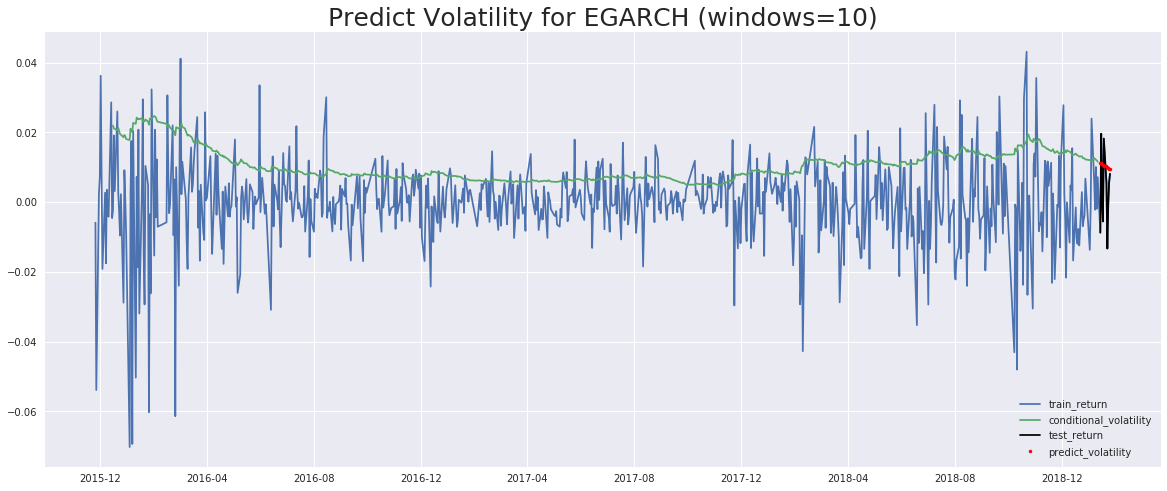

In [148]:
plt.figure(figsize=(20,8))
plt.plot(HS300_close['return'],label='train_return')
plt.plot(res_EGARCH.conditional_volatility,label='conditional_volatility')
x=test_GARCH.index
plt.plot(test_GARCH,'black',label='test_return')
plt.plot(x,pre_volatility4,'.r',label='predict_volatility')
plt.title('Predict Volatility for EGARCH (windows=10)',size=25)
plt.legend()

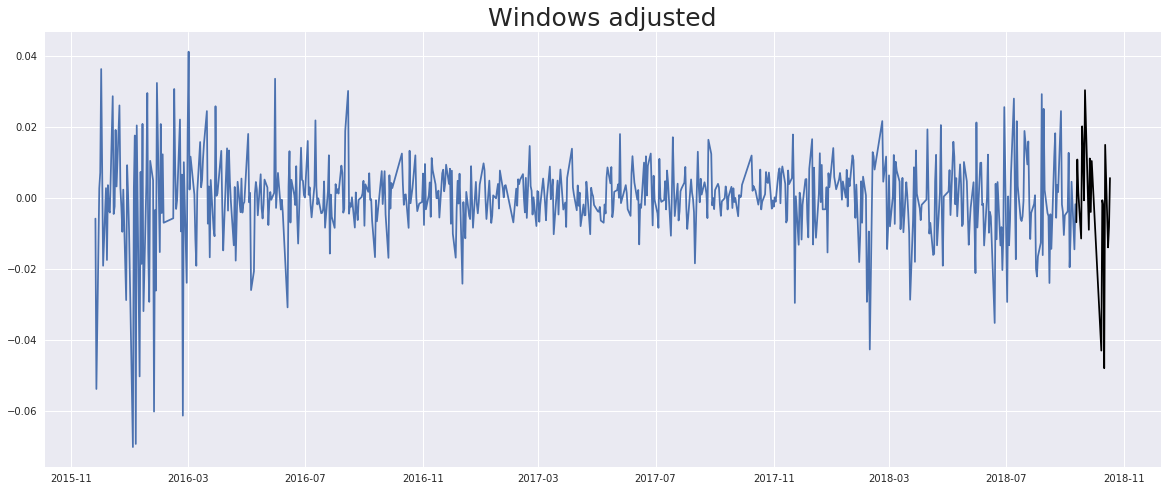

In [175]:
train_GARCH =HS300_close['return'][:-90]
test_GARCH=HS300_close['return'][-90:-70]
plt.figure(figsize=(20,8))
plt.plot(train_GARCH,label='train_return')
plt.plot(test_GARCH,'black',label='train_return')
plt.title('Windows adjusted',size=25)

In [176]:
am_EGARCH = arch.arch_model(train_GARCH, mean='AR',lags=14,vol='EGARCH',p=1,o=1,q=1) 
res_EGARCH = am_EGARCH.fit()
res_EGARCH.summary()

Iteration:      1,   Func. Count:     21,   Neg. LLF: -2169.007370178313
Iteration:      2,   Func. Count:     50,   Neg. LLF: -2170.104989744267
Iteration:      3,   Func. Count:     75,   Neg. LLF: -2174.819787421421
Iteration:      4,   Func. Count:    100,   Neg. LLF: -2181.4072561108987
Iteration:      5,   Func. Count:    125,   Neg. LLF: -2182.6400417739997
Iteration:      6,   Func. Count:    150,   Neg. LLF: -2183.3541459095477
Iteration:      7,   Func. Count:    174,   Neg. LLF: -2183.6454564045707
Iteration:      8,   Func. Count:    198,   Neg. LLF: -2183.67288619292
Iteration:      9,   Func. Count:    222,   Neg. LLF: -2183.70542733032
Iteration:     10,   Func. Count:    245,   Neg. LLF: -2183.774329729851
Iteration:     11,   Func. Count:    268,   Neg. LLF: -2184.632653254718
Iteration:     12,   Func. Count:    292,   Neg. LLF: -2185.32689539461
Iteration:     13,   Func. Count:    316,   Neg. LLF: -2185.3698854231643
Iteration:     14,   Func. Count:    340,   Neg. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR - EGARCH Model Results                           
==============================================================================
Dep. Variable:                 return   R-squared:                       0.033
Mean Model:                        AR   Adj. R-squared:                  0.013
Vol Model:                     EGARCH   Log-Likelihood:                2188.29
Distribution:                  Normal   AIC:                          -4338.57
Method:            Maximum Likelihood   BIC:                          -4252.91
                                        No. Observations:                  671
Date:                Tue, Feb 12 2019   Df Residuals:                      652
Time:                        19:55:55   Df Model:                           19
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const      4.0898e-04  1.279e-04      3.197  1.388e-03   [1.583e-04,6.597e-04]
return[1]  7.6425e-03  1.134e-02      0.674      0.501  [-1.459e-02,2.988e-02]
return[2]  7.5947e-03  6.729e-03      1.129      0.259  [-5.594e-03,2.078e-02]
return[3]      0.0435  1.717e-02      2.535  1.123e-02   [9.879e-03,7.718e-02]
return[4]     -0.0703  2.168e-03    -32.413 1.805e-230 [-7.451e-02,-6.601e-02]
return[5]     -0.0637  1.858e-02     -3.429  6.048e-04    [ -0.100,-2.731e-02]
return[6]      0.0426  1.261e-02      3.382  7.184e-04   [1.793e-02,6.734e-02]
return[7]     -0.0149  1.301e-02     -1.142      0.253  [-4.035e-02,1.064e-02]
return[8]  6.7249e-03  4.881e-03      1.378      0.168  [-2.842e-03,1.629e-02]
return[9]      0.0724  9.520e-03      7.610  2.745e-14   [5.378e-02,9.110e-02]
return[10]     0.0315  7.572e-03      4.165  3.108e-05   [1.670e-02,4.638e-02]
return[11] 3.6661e-03  4.962e-03      0.739      0.460  [-6.059e-03,1.339e-02]
return[12]    -0.0951  1.801e-02     -5.282  1.275e-07    [ -0.130,-5.984e-02]
return[13]     0.0242  6.415e-03      3.765  1.663e-04   [1.158e-02,3.673e-02]
return[14]    -0.0464  1.161e-02     -3.993  6.521e-05 [-6.912e-02,-2.361e-02]
                               Volatility Model                               
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
omega          -0.0585  5.811e-02     -1.006      0.314    [ -0.172,5.540e-02]
alpha[1]        0.0956  3.412e-02      2.801  5.102e-03    [2.868e-02,  0.162]
gamma[1]   -3.2098e-03  3.021e-02     -0.106      0.915 [-6.242e-02,5.600e-02]
beta[1]         0.9934  6.080e-03    163.403      0.000      [  0.982,  1.005]
==============================================================================

Covariance estimator: robust
"""

<img src="http://u.thsi.cn/imgsrc/sns/d577ff69e9608cf8a1a6db8796d0f730_1292_136.png" width = "600" height = "600" div align=center />


In [169]:
import math
resid=res_EGARCH.resid[-14:]                 #取出过去14天的残差at
params=np.array(res_EGARCH.params[1:15])               #取出均值方程所有系数    
w_params=params[::-1]                       #倒转系数方向
w_params.dot(resid[-14:])

for i in range(20):
    resid_new=test_GARCH.iloc[i]-(res_EGARCH.params[0]+w_params.dot(resid[-14:]))
    resid=np.append(resid,resid_new)
resid_final=resid[-20:]


volatility=res_EGARCH.conditional_volatility[-1:]

for i in range(20):
    if resid_final[i]>=0:
        new_volatility6=math.exp(-0.0585+0.0956*((resid_final_square[i]-3.2098e-03*resid_final_square[i])/volatility[-1])+0.9934*math.log(volatility[-1],math.e))
    if resid_final[i]<0:
        new_volatility6=math.exp(-0.0585+0.0956*((-resid_final_square[i]-3.2098e-03*resid_final_square[i])/volatility[-1])+0.9934*math.log(volatility[-1],math.e))
     
    volatility=np.append(volatility,new_volatility6)
    
pre_volatility6=volatility[-20:]
pre_volatility6

array([0.01278126, 0.01244717, 0.01208711, 0.01172983, 0.01139998,
       0.01108409, 0.01077366, 0.01046992, 0.0101744 , 0.00990688,
       0.0096323 , 0.00936931, 0.00910224, 0.00885404, 0.00855022,
       0.00831962, 0.00809995, 0.00788314, 0.00767639, 0.00748275])

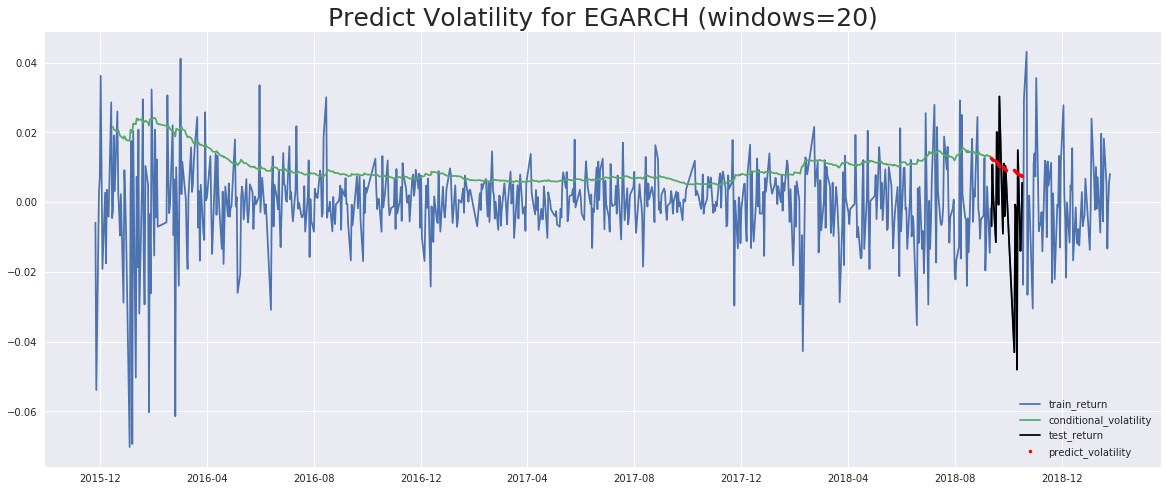

In [177]:
plt.figure(figsize=(20,8))
plt.plot(HS300_close['return'],label='train_return')
plt.plot(res_EGARCH.conditional_volatility,label='conditional_volatility')
x=test_GARCH.index
plt.plot(test_GARCH,'black',label='test_return')
plt.plot(x,pre_volatility6,'.r',label='predict_volatility')
plt.title('Predict Volatility for EGARCH (windows=20)',size=25)
plt.legend()